In [15]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt

In [40]:
full_transactions_file = 'data/transaction_dataset.parquet'
full_accounts_file = 'data/account_dataset.parquet'
train_target_file = 'data/train_target_dataset.parquet'

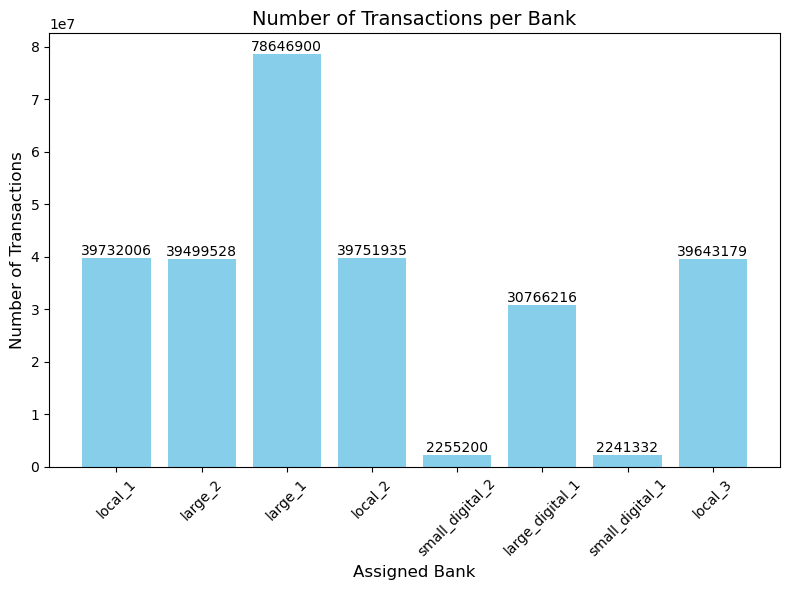

In [18]:
# count number of outgoing transactions per bank
df_txn_count = duckdb.sql(f"""
           SELECT acc.assigned_bank, COUNT(txn.*) AS num_txns
           FROM '{full_accounts_file}' acc
              JOIN '{full_transactions_file}' txn ON txn.account_id = acc.account_id AND txn.transaction_direction = 'outbound'
           GROUP BY acc.assigned_bank
           """).df()

plt.figure(figsize=(8, 6))
bars = plt.bar(df_txn_count['assigned_bank'], df_txn_count['num_txns'], color='skyblue')
# Annotate bars with values
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        bar.get_height(),  # Y-coordinate (top of the bar)
        f'{int(bar.get_height())}',  # Text to display (bar height)
        ha='center', va='bottom', fontsize=10  # Alignment and font size
    )
plt.xlabel('Assigned Bank', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.title('Number of Transactions per Bank', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [21]:
# descriptive stats of txns
duckdb.sql(f"""
            SELECT COUNT(*) AS row_count,
            AVG(amount) AS mean_value,
            MIN(amount) AS min_value,
            MAX(amount) AS max_value,
            STDDEV(amount) AS stddev_value,
            PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY amount) AS median_value
            FROM '{full_transactions_file}'
            """)

┌───────────┬───────────────────┬───────────┬───────────┬────────────────────┬──────────────┐
│ row_count │    mean_value     │ min_value │ max_value │    stddev_value    │ median_value │
│   int64   │      double       │  double   │  double   │       double       │    double    │
├───────────┼───────────────────┼───────────┼───────────┼────────────────────┼──────────────┤
│ 307596577 │ 477.0301788044005 │       0.0 │ 6159153.0 │ 3532.0937101735885 │         50.0 │
└───────────┴───────────────────┴───────────┴───────────┴────────────────────┴──────────────┘

Notes:
- There are 0 value transactions that should be excluded from analysis. 
- Most transactions are small-value transactions.

## Explore categorical features

In [31]:
def count_cat_feat(cat_feature: str):
    df = duckdb.sql(f"""
        SELECT {cat_feature}, COUNT(*) AS num_txns
        FROM '{full_transactions_file}'
        GROUP BY {cat_feature}
    """).df()

    plt.figure(figsize=(12, 5))
    bars = plt.bar(df[cat_feature], df['num_txns'])
    # Annotate bars with values
    for bar in bars:
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
            bar.get_height(),  # Y-coordinate (top of the bar)
            f'{int(bar.get_height())}',  # Text to display (bar height)
            ha='center', va='bottom', fontsize=10  # Alignment and font size
        )
    plt.xlabel(cat_feature, fontsize=12)
    plt.ylabel('Number of Transactions', fontsize=12)
    plt.title(f'Number of Transactions per {cat_feature}', fontsize=14)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

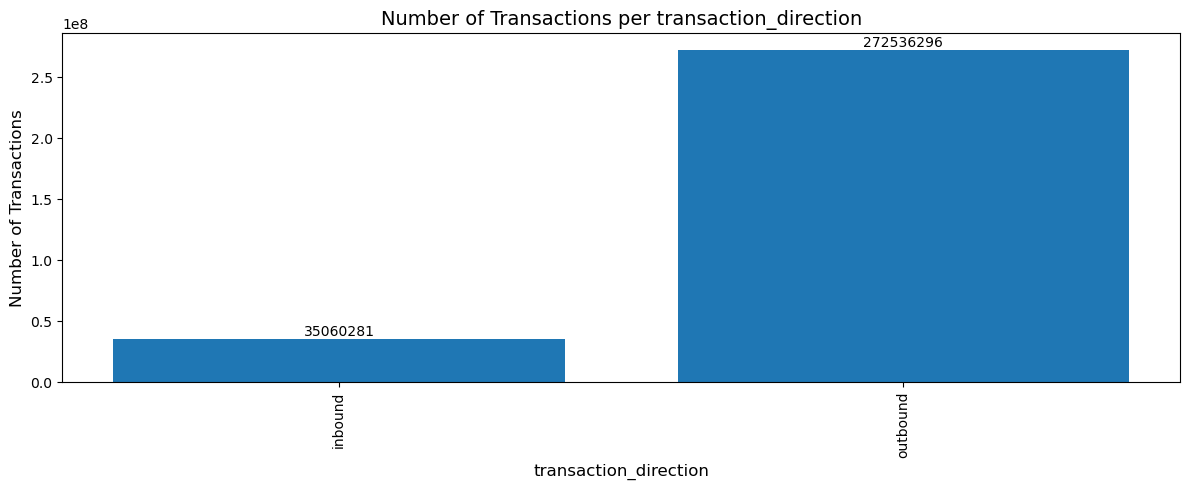

In [32]:
count_cat_feat('transaction_direction')

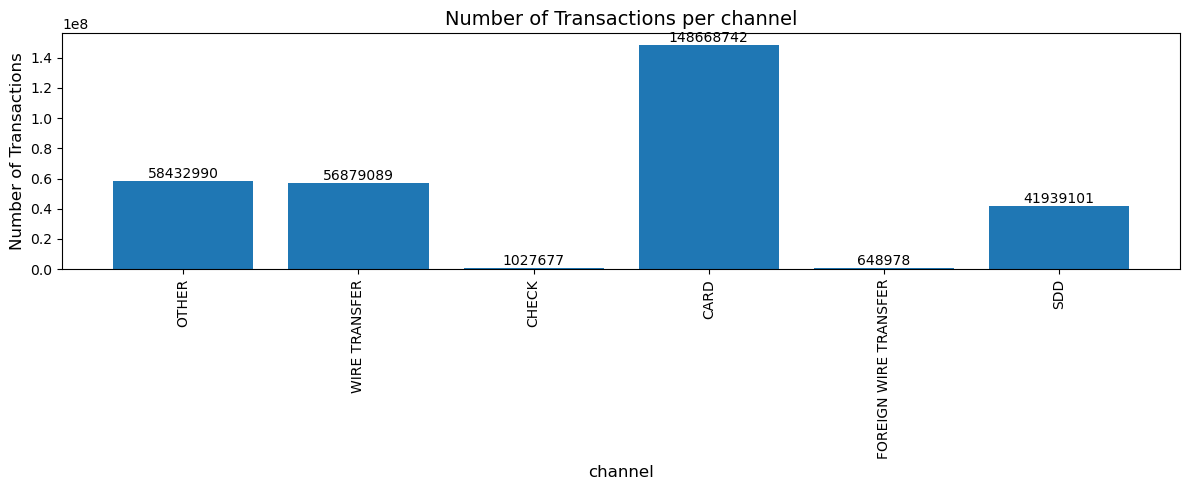

In [33]:
count_cat_feat('channel')

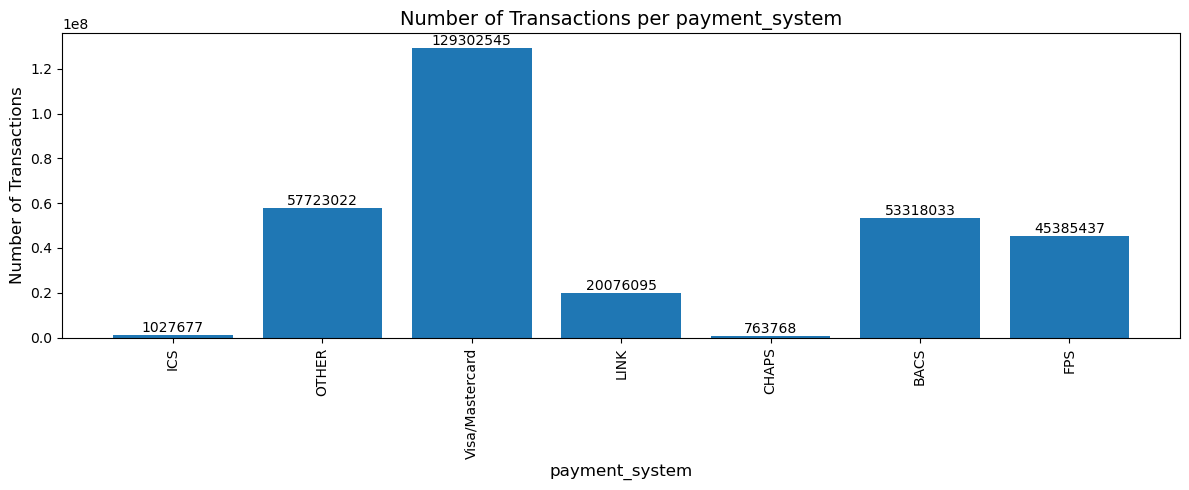

In [34]:
count_cat_feat('payment_system')

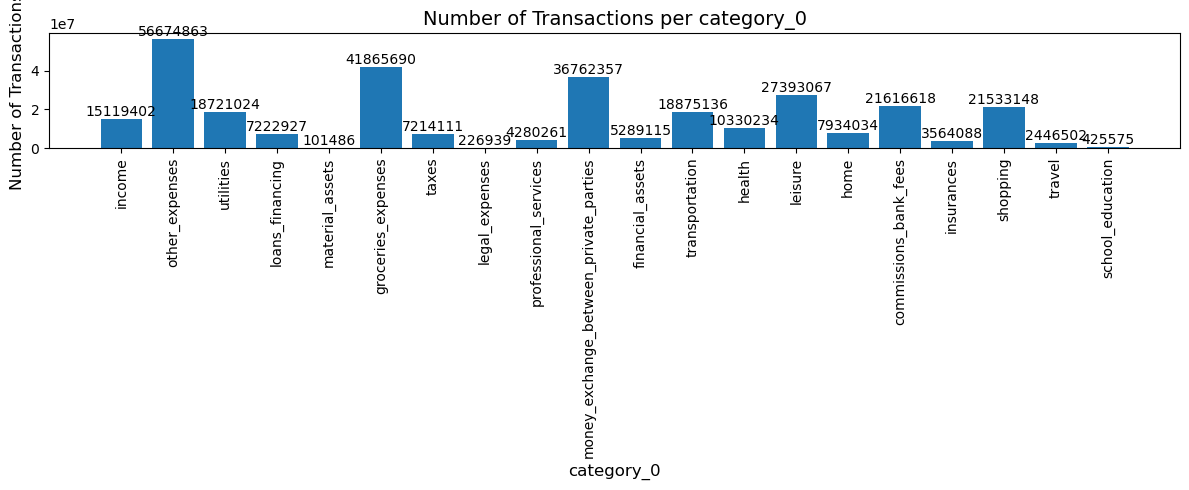

In [35]:
count_cat_feat('category_0')

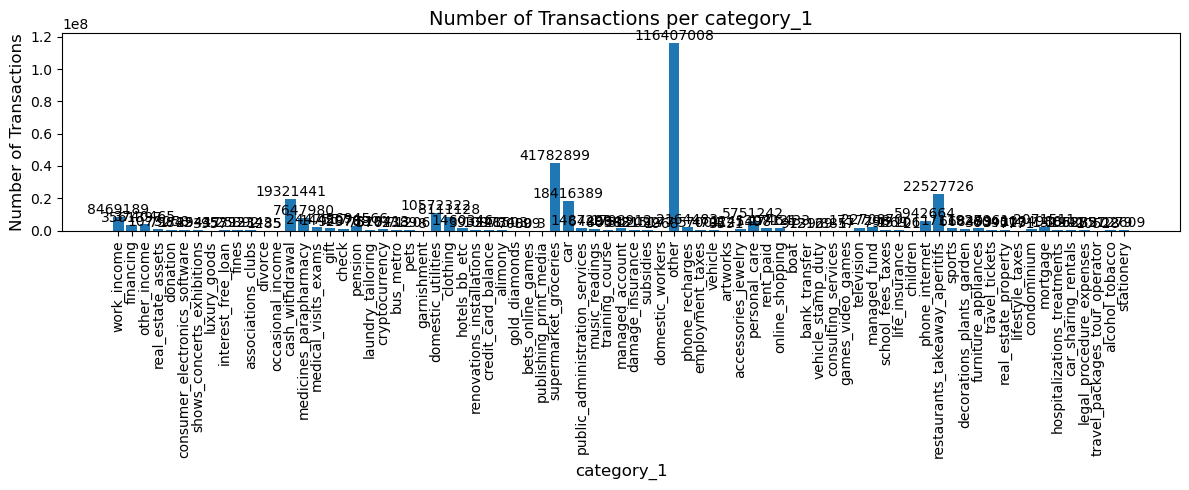

In [36]:
count_cat_feat('category_1')

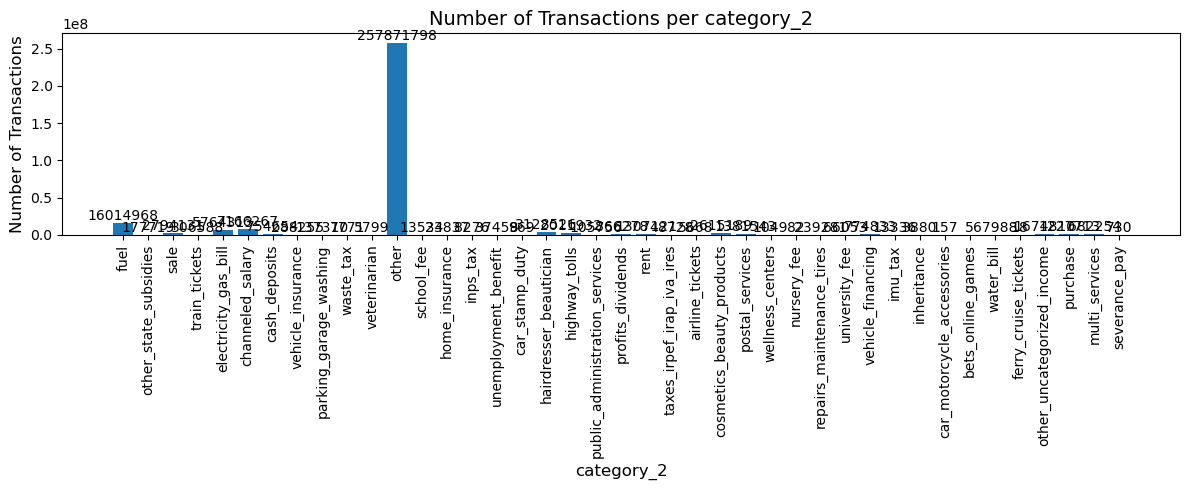

In [38]:
count_cat_feat('category_2')

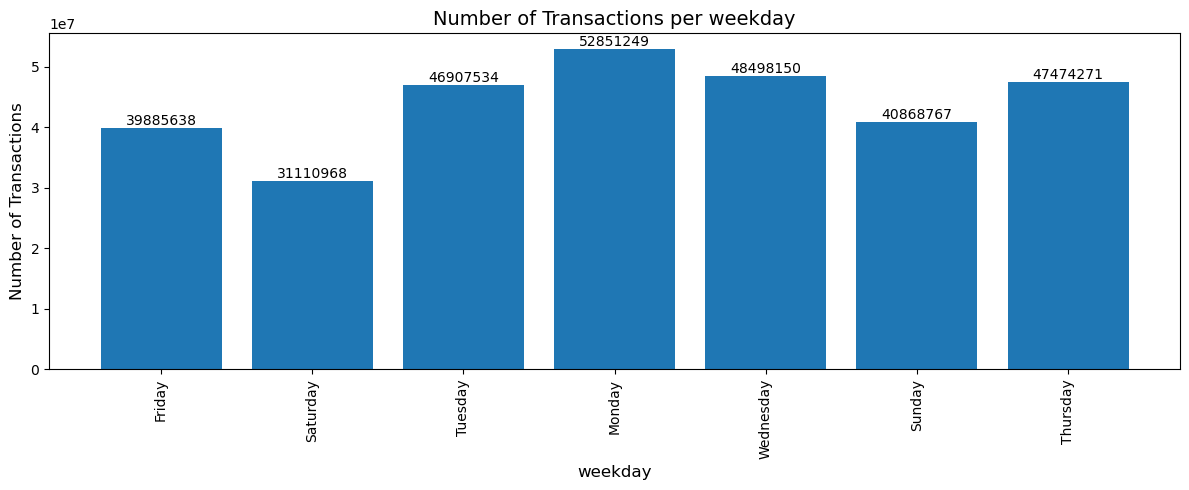

In [39]:
count_cat_feat('weekday')

In [13]:
numeric_columns = ['']

,transaction_id,account_id,month,day,weekday,hour,min,sec,transaction_direction,channel,payment_system,category_0,category_1,category_2,amount,counterpart_id,__index_level_0__
0,0,0,1,4,Saturday,0,0,15,inbound,WIRE TRANSFER,BACS,income,pension,other,515.00,pension_1,100373971
1,1,0,1,5,Sunday,10,37,42,outbound,OTHER,OTHER,taxes,other,other,8.60,taxes_1,108510778
2,2,0,1,9,Thursday,0,8,27,outbound,OTHER,OTHER,commissions_bank_fees,other,other,2.00,bank_commission_1,250135977
3,4,0,2,1,Saturday,0,0,40,inbound,WIRE TRANSFER,BACS,income,pension,other,515.00,pension_1,100373972
4,3,0,2,1,Saturday,11,35,56,outbound,OTHER,OTHER,other_expenses,other,other,2000.00,other_1,295935637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,94534730,1,2,10,Monday,18,24,39,inbound,WIRE TRANSFER,FPS,money_exchange_between_private_parties,other,other,136.00,556357,134897638
96,83,1,2,10,Monday,21,12,46,outbound,OTHER,OTHER,taxes,other,other,5407.00,taxes_1,108510784
97,84,1,2,11,Tuesday,16,40,40,outbound,CARD,Visa/Mastercard,groceries_expenses,supermarket_groceries,other,45.90,supermarket_groceries_15,43944925
98,85,1,2,12,Wednesday,11,15,15,outbound,CARD,Visa/Mastercard,groceries_expenses,supermarket_groceries,other,55.78,supermarket_groceries_176,87146059


In [41]:
df_fraud_by_bank_and_month = duckdb.sql(f"""
           SELECT txn.month, acc.assigned_bank, COUNT(txn.*) AS num_fraud_txn
           FROM '{full_transactions_file}' txn
             JOIN '{train_target_file}' launder ON launder.transaction_id = txn.transaction_id
             JOIN '{full_accounts_file}' acc ON txn.account_id = acc.account_id AND txn.transaction_direction = 'inbound'
           GROUP BY txn.month, acc.assigned_bank
           """).df()

print(df_fraud_by_bank_and_month)

    month    assigned_bank  num_fraud_txn
0       4          local_2            283
1       2          large_1            357
2      10          large_1             84
3       1          large_1            293
4       3          large_1            531
..    ...              ...            ...
82      9  small_digital_2              3
83      8          large_2            196
84      4          local_1            204
85     11          local_3             18
86     11  large_digital_1             11

[87 rows x 3 columns]
